
# Data Cleaning

## Objectives

The purpose of this notebook is to **clean, standardize, and prepare the collected datasets** for subsequent exploratory analysis and modeling tasks.

The goal is to transform raw inputs from multiple book datasets into a **reliable, consistent, and mergeable analytical base**, ensuring data integrity and comparability across platforms.

---

## Inputs

| Dataset                    | Source                     | Description                                                               | Format |
| -------------------------- | -------------------------- | ------------------------------------------------------------------------- | ------ |
| `bbe_books.csv`            | Zenodo – *Best Books Ever* | Book metadata including title, author, rating, genres, and description.   | CSV    |
| `books.csv`, `ratings.csv` | GitHub – *Goodbooks-10k*   | Book metadata and user–book interaction data for recommendation modeling. | CSV    |

---

## Tasks in This Notebook

This notebook will execute the following cleaning and preparation steps:

1. **Standardize column formats:**
   Ensure consistent data types and naming conventions across datasets (e.g., convert `isbn` to string, align `author`, `rating`, and `title` formats).

2. **Clean and normalize missing values:**
   Replace placeholder NaNs (`9999999999999`, empty lists, or `"None"`) with `np.nan`, then impute or drop based on analytical importance.

3. **Detect and resolve duplicates:**
   Identify duplicate records using key identifiers (`bookId`, `isbn`, `title + author`) and retain the most complete or relevant entries.

4. **Validate and align categorical values:**
   Standardize genre labels, language codes, and rating scales to ensure comparability between datasets.

5. **Merge compatible datasets:**
   Integrate *BestBooksEver* and *Goodbooks-10k_books* into a unified schema while maintaining referential integrity with the ratings dataset.

6. **Outlier and consistency checks:**
   Review numerical and date fields (e.g., `pages`, `price`, `publishDate`) for unrealistic or extreme values and adjust as needed.

7. **Feature enrichment (optional):**
   Derive or enhance fields such as `popularity_score`, `recency`, or missing genre information using external APIs where beneficial.

---

## Outputs

* **Cleaned, schema-aligned datasets** ready for exploratory data analysis and modeling.
* **Summary statistics** on completeness, duplicates, and outliers.
* **Processed CSV files** saved for reproducibility in `data/processed/`.

> **Note:** This notebook focuses on the *Data Cleaning and Preparation*. Further feature engineering and model-specific transformations will follow in later notebooks.

---


## Navigate to the Parent Directory

Before combining and saving datasets, it’s often helpful to move to a parent directory so that file operations (like loading or saving data) are easier and more organized. 

Before using the Python’s built-in os module to move one level up from the current working directory, it is advisable to inspect the current directory.

In [1]:
import os

# Get the current working directory
current_dir = os.getcwd()
print(f'Current directory: {current_dir}')

Current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics\notebooks


To change to parent directory (root folder), run the code below. If you are already in the root folder, you can skip this step.

In [2]:
# Change the working directory to its parent
os.chdir(os.path.dirname(current_dir))
print('Changed directory to parent.')

# Get the new current working directory (the parent directory)
current_dir = os.getcwd()
print(f'New current directory: {current_dir}')

Changed directory to parent.
New current directory: c:\Users\reisl\OneDrive\Documents\GitHub\bookwise-analytics


## Load and Inspect Books Datasets

In this step, we load the previously collected datasets: **Goodbooks-10k** (books) and **Best Books Ever**. We will inspect their structure one more time before starting any merging or cleaning operations.

In [ ]:
import pandas as pd 

# load datasets
books_raw = pd.read_csv('data/raw/books.csv')
bbe_raw = pd.read_csv('data/raw/bbe_books.csv')

# create copies for cleaning
books_clean = books_raw.copy()
bbe_clean = bbe_raw.copy()

In [ ]:
from pathlib import Path

# Create data folder if not exists
interim_bbe_path = Path("data/interim/bbe")
interim_bbe_path.mkdir(parents=True, exist_ok=True)

interim_gb_path = Path("data/interim/goodbooks")
interim_gb_path.mkdir(parents=True, exist_ok=True)

version = 0

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)
books_clean.to_csv(interim_gb_path / f"books_clean_v{version}.csv", index=False)

print("Interim datasets saved successfully in data/interim/ directory.")

In [ ]:
# Preview data
display(bbe_clean.head(3))
display(books_clean.head(3))

# Check shape and missing values
for name, df in {'BBE': bbe_clean, 'Books': books_clean,}.items():
    print(f"\n{name} — Shape: {df.shape}")
    print(df.info())
    print(df.isna().sum().sort_values(ascending=False).head())


We will check if the datasets share common identifiers and compatible data types.

In [ ]:
bbe_only_columns = set(bbe_clean.columns) - set(books_clean.columns)
print(f'Columns only in BBE: {bbe_only_columns}')

goodbooks_only_columns = set(books_clean.columns) - set(bbe_clean.columns)
print(f'Columns only in Goodbooks: {goodbooks_only_columns}')

Based on the initial inspection, we can create a mapping table to align columns from both datasets for merging and analysis.

| **BestBooksEver (BBE)** | **Goodbooks10k_books (GB10k)** | **Notes / Alignment Rationale** |
| --------------------------------- | ------------------------------------------------ | -------------------------------------------------------------------------- |
| `bookId` | `book_id` | Main identifier; ensure both are numeric. |
| `bookId_num` | `goodreads_book_id` | Goodreads identifier; ensure both are numeric for joining. |
| `title` | `title` | Direct match. Used as secondary join key. |
| `series` | — | Only in BBE; could enrich GB10k if available via API. |
| `author` | `authors` | Same meaning. Normalize format. |
| `rating` | `average_rating` | Equivalent — rename to unified `average_rating`. |
| `numRatings` | `ratings_count` | Same measure of total user ratings. |
| `ratingsByStars` | `ratings_1` … `ratings_5` | BBE has dict, GB10k has explicit columns. Expand or aggregate accordingly. |
| `likedPercent` | — | BBE-only; optional metric of user sentiment. |
| `isbn` | `isbn` / `isbn13` | Common linking key; keep both (string). Use for merges when present. |
| `language` | `language_code` | Standardize to ISO 639-1 (lowercase). |
| `description` | — | BBE-only; valuable for NLP features. |
| `genres` | — | BBE-only; can enrich GB10k tags later. |
| `characters` | — | bbe_clean-only; low modeling priority, but could add narrative metadata. |
| `bookFormat` | — | BBE-only; possible categorical feature. |
| `edition` | — | BBE-only. |
| `pages` | — | BBE-only; numeric, may enrich GB10k metadata. |
| `publisher` | — | bbe_clean_clean-only; possible future feature. |
| `publishDate` | — | bbe_clean_clean-only; can approximate from GB10k’s `original_publication_year`. |
| `firstPublishDate` | `original_publication_year` | Equivalent (date vs year). |
| `coverImg` | `image_url` / `small_image_url` | Same function (cover link). |
| `bbeScore` | — | BBE-only; internal popularity score. |
| `bbeVotes` | `work_ratings_count` | Comparable as popularity proxy. |
| `price` | — | BBE-only; likely non-essential for satisfaction prediction. |
| `setting` | — | BBE-only; can support content enrichment. |
| `awards` | — | BBE-only; categorical enrichment. |
| — | `goodreads_book_id` / `best_book_id` / `work_id` | GB10k-only identifiers; may be used for deeper Goodreads linking. |
| — | `books_count` | GB10k-only; number of editions per work. |
| — | `work_text_reviews_count` | GB10k-only; can complement `numRatings` as engagement metric. |



## Data Cleaning Steps

### Best Books Ever

- Handle identifier columns
- Standardize key columns: `author`, `language`
- Missing data handling strategies
- Normalize genre and format
- Validate for no nulls or duplicates

#### 1. Handle identifier columns
On the previous notebook, we created a new field `bookId_num` in the BBE dataset to align with `goodreads_book_id` in the Goodbooks10k dataset. We have also ensured that they were both converted to numeric types and that all `bookId` values generated a valid `bookId_num`. So we can skip the handle identifier columns, as it was already done. 

#### 2. Standardize key columns

**Author**

We will proceed with the standardization of key columns, starting with the `author` column. The author column in the BBE dataset often contains a qualifier such as "(Goodreads Author)". We will remove such qualifiers to standardize the format. We will also create an additional list column to store multiple authors as a list rather than a single string. This way, its is ready to use for feature engineering later on if needed.

In [ ]:
import re
import pandas as pd

def clean_and_split_authors(name):
    """
    Cleans author names and returns a list of authors.
    """
    if pd.isna(name):
        return None

    # Remove role descriptors
    cleaned = re.sub(r"\s*\([^)]*\)", "", name)
    
    # Split into list if multiple authors exist
    authors_list = [a.strip() for a in cleaned.split(",") if a.strip()]
    
    return authors_list

In [ ]:
# Apply to BestBooksEver dataset
bbe_clean["authors_list"] = bbe_clean["author"].apply(clean_and_split_authors)
bbe_clean["author_clean"] = bbe_clean["authors_list"].apply(lambda x: ", ".join(x) if isinstance(x, list) else None)

# Quick check
bbe_clean[["author", "author_clean", "authors_list"]].head(5)

In [ ]:
from pathlib import Path

version = 1

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim author datasets saved successfully in data/interim/ directory.")

**Language**

The `language` column in the Best Books Ever dataset used full names such as “English”, “German”, and “Arabic”.  Before transforming the values, we will check for all unique values to identify any unexpected entries.

In [ ]:
# Inspect unique language values
print("Unique language values in BBE dataset:")
bbe_clean['language'] = bbe_clean['language'].astype(str).str.strip()
unique_languages = bbe_clean['language'].unique()

print(f"\nTotal unique values: {len(unique_languages)}\n")
print(unique_languages)

We can see that there are some unexpected values such as:
- _historical forms_ (“English, Middle (1100-1500)”, “French, Middle (ca.1400-1600)”)
- _combined or semicolon-separated entries_ (“Filipino; Pilipino”, “Catalan; Valencian”)
- _multi-language / uncertain cases_ (“Multiple languages”, “Undetermined”)
- _rare or dialects_ (“Bokmål, Norwegian; Norwegian Bokmål”, “Aromanian; Arumanian; Macedo-Romanian”)

We will clean the unusual entries by mapping them to the closest language present in the ISO 639-1 standard. Unrecognized values will be flagged and replaced with `"unknown"`. It was decided to distinguish the `"unknown"` from the `NaN` values to retain information about missingness versus unrecognized entries. 

In [ ]:
import numpy as np

# Standardize capitalization & spacing
bbe_clean['language'] = bbe_clean['language'].astype(str).str.strip().str.title()

# Handle NaNs that became strings
bbe_clean['language'] = bbe_clean['language'].replace({'Nan': np.nan})

# Simplify and unify multi-language / dialect forms
replace_map = {
    'Multiple Languages': 'Multilingual',
    'Undetermined': 'Unknown',
    'Iranian (Other)': 'Persian',
    'Farsi': 'Persian',
    'Filipino; Pilipino': 'Filipino',
    'Catalan; Valencian': 'Catalan',
    'Panjabi; Punjabi': 'Punjabi',
    'Bokmål, Norwegian; Norwegian Bokmål': 'Norwegian',
    'Norwegian Nynorsk; Nynorsk, Norwegian': 'Norwegian',
    'Greek, Modern (1453-)': 'Greek',
    'Greek, Ancient (To 1453)': 'Greek',
    'French, Middle (Ca.1400-1600)': 'French',
    'English, Middle (1100-1500)': 'English',
    'Dutch, Middle (Ca.1050-1350)': 'Dutch',
    'Aromanian; Arumanian; Macedo-Romanian': 'Romanian',
    'Mayan Languages': 'Mayan',
    'Australian Languages': 'English'
}

bbe_clean['language'] = bbe_clean['language'].replace(replace_map)



After transforming the values, we apply a mapping to standardize the `language` column using **ISO 639-1 two-letter codes**.
The mapping dictionaries are stored in the `src/cleaning/mappings/` folder to keep the notebooks cleaner and improve readability.

In [ ]:
import json

with open("src/cleaning/mappings/languages_dict.json", "r", encoding="utf-8") as f:
    languages_dict = json.load(f)

# Apply dictionary
bbe_clean['language_clean'] = bbe_clean['language'].str.lower().map(languages_dict)

# Fill remaining NaNs
bbe_clean['language_clean'] = bbe_clean['language_clean'].fillna('unknown')

In [ ]:
# check again for unique language values
print("Unique language values in BBE dataset:")
unique_languages = bbe_clean['language_clean'].unique()

print(f"\nTotal unique values: {len(unique_languages)}\n")
print(unique_languages)

In [ ]:
language_breakdown = (
    bbe_clean['language']
    .value_counts()
    .to_frame('count')
)

language_breakdown['percentage'] = (
    language_breakdown['count'] / len(bbe_clean) * 100
).round(2)

print(language_breakdown)


In [ ]:
from pathlib import Path

version = 2

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim language datasets saved successfully in data/interim/ directory.")

**Dates**

BBE dataset has two publication fields: `publishDate` and `firstPublishDate`. The `firstPublishDate` represents the original publication date, while `publishDate` refers to a more recent edition or reprint date. Publishing experts assumption is that the recency of the `firstPublishDate` is more relevant for modeling book satisfaction, as it reflects when the book was first introduced to readers. Therefore, we will focus on cleaning and standardizing the `firstPublishDate` column and use `publishDate` only if `firstPublishDate` is missing.

While majority of the dates follow the 'MM/DD/YY' format, after a first attemp at cleaning, we noticed some dates do not conform to this format. Therefore, we will implement a more robust date parsing strategy, focusing first on transforming textual formats into 'MM/DD/YYYY' format before attempting to parse them into datetime objects.

In [ ]:
from dateutil import parser

def clean_date_string(date_str):
    """Remove ordinal suffixes and unwanted characters from a date string."""
    if pd.isna(date_str):
        return np.nan
    # remove st, nd, rd, th (like 'April 27th 2010' → 'April 27 2010')
    cleaned = re.sub(r'(\d+)(st|nd|rd|th)', r'\1', str(date_str))
    return cleaned.strip()

def parse_mixed_date(date_str):
    """Try to parse a variety of date formats safely."""
    if pd.isna(date_str) or date_str == '':
        return np.nan
    try:
        # Use dateutil to parse most human-readable formats
        return parser.parse(date_str, fuzzy=True)
    except Exception:
        # Try year-only fallback (e.g. '2003')
        match = re.match(r'^\d{4}$', str(date_str))
        if match:
            return pd.to_datetime(f"{date_str}-01-01")
        return np.nan

In [ ]:
# Apply cleaning to both columns
for col in ['firstPublishDate', 'publishDate']:
       bbe_clean[f'{col}_clean'] = (
        bbe_clean[col]
        .astype(str)
        .replace({'nan': np.nan, '': np.nan})
        .apply(clean_date_string)
        .apply(parse_mixed_date)
    )

In [ ]:
# Combine using your logic: prefer firstPublishDate, else publishDate
bbe_clean['publication_date_clean'] = (
    bbe_clean['firstPublishDate_clean'].combine_first(bbe_clean['publishDate_clean'])
)
# Reconvert to datetime safely before using .dt
bbe_clean['publication_date_clean'] = pd.to_datetime(bbe_clean['publication_date_clean'], errors='coerce')

# Format as ISO standard
bbe_clean['publication_date_clean'] = bbe_clean['publication_date_clean'].dt.strftime("%Y-%m-%d")

# Check a sample of remaining nulls
bbe_clean[bbe_clean['publication_date_clean'].isna()][['title', 'firstPublishDate', 'publishDate', 'publication_date_clean']].head(10)

In [ ]:
# Filter rows where the unified publication date is missing
total = len(bbe_clean)
bbe_missing_dates = bbe_clean.loc[bbe_clean['publication_date_clean'].isna()]
missing_count = len(bbe_missing_dates)

print(f"Missing publication dates: {missing_count} of {total} ({missing_count/total:.2%})")

# Preview key columns
bbe_missing_dates[['title', 'author', 'firstPublishDate', 'publishDate', 'publication_date_clean']].head(10)

In [ ]:
from pathlib import Path

version = 3

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim dates datasets saved successfully in data/interim/ directory.")

**Publisher**

Publisher names can vary significantly in formatting, including differences in capitalization, punctuation, and spacing. To standardize the `publisher` column, we will convert all entries to lowercase and strip any leading or trailing whitespace. This will help reduce variability and improve consistency across the dataset.

In [ ]:
print("Sample publishers:")
print(bbe_clean['publisher'].drop_duplicates().sample(30, random_state=42).values)

In [ ]:

# Strip, lowercase, remove extra spaces and punctuation
bbe_clean['publisher'] = (
    bbe_clean['publisher']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
    .str.replace(r'[.,]', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
)


In [ ]:
# Inspect unique publisher values 
bbe_clean['publisher'] = bbe_clean['publisher'].astype(str).str.strip() 
unique_publisher = bbe_clean['publisher'].unique() 

print(f"\nTotal unique publisher values: {len(unique_publisher)}\n") 

In [ ]:
# normalize numeric publishers names:
def clean_numeric_publishers(x):
    if re.match(r'^\d+$', x.strip()):
        return 'unknown'
    return x

bbe_clean['publisher'] = bbe_clean['publisher'].apply(clean_numeric_publishers)


This cleaning step reduced the number of unique publisher names from **11,111 to 10,764**.
Since **English-language books represent 81% of the catalogue**, the analysis will focus on this segment.
We will **standardize major English-language publishing groups**, consolidating their **imprints and subsidiaries**, and apply **fuzzy matching** to unify names with **minor variations**.

In [ ]:
# load publishers dictionary
with open("src/cleaning/mappings/publishers_dict.json", "r", encoding="utf-8") as f:
    publishers_dict = json.load(f)

In [ ]:
from rapidfuzz import process, fuzz

# Get top 10000 most common publishers
top_n = 10000
publisher_counts = bbe_clean['publisher'].value_counts()
top_publishers = publisher_counts.head(top_n).index.tolist()

# Create a mapping for top publishers only
standardization_map = {}
processed = set()

for pub in top_publishers:
    if pub in processed:
        continue
    
    # Find similar publishers in the top list
    matches = process.extract(pub, top_publishers, scorer=fuzz.ratio, limit=5)
    
    # Group similar ones (score > 90)
    similar = [m[0] for m in matches if m[1] > 90]
    canonical = similar[0]  # Use first as canonical
    
    for similar_pub in similar:
        standardization_map[similar_pub] = canonical
        processed.add(similar_pub)

# Apply the mapping
bbe_clean['publisher_standardized'] = bbe_clean['publisher'].replace(standardization_map)

# Then apply manual mapping
bbe_clean['publisher_standardized'] = bbe_clean['publisher_standardized'].replace(publishers_dict)

In [ ]:
standardized_unique_publisher = bbe_clean['publisher_standardized'].unique() 

print(f"\nTotal unique publisher values: {len(standardized_unique_publisher)}\n") 

print("Sample publishers:")
print(bbe_clean['publisher_standardized'].drop_duplicates().sample(30, random_state=42).values)

The cleaning process reduced the number of unique publisher names from **11,111 to 9993**, representing a **10% decrease**.
Given that the dataset includes books in multiple languages and many small or independent publishers, this reduction is a **satisfactory outcome**.

To further evaluate the effectiveness of the cleaning, we will analyze the **proportion of titles associated with the most common publishers**.
This will help us assess how well the standardization process **consolidated the publisher catalog** and captured the main publishing groups.

In [ ]:
# Define your core publisher groups
major_publishers = [
    'penguin random house', 'harpercollins', 'macmillan',
    'simon & schuster', 'hachette', 'bloomsbury',
    'amazon publishing', 'scholastic'
]

# Create a flag
bbe_clean['is_major_publisher'] = bbe_clean['publisher_standardized'].isin(major_publishers)

# Count results
total_books = len(bbe_clean)
major_books = bbe_clean['is_major_publisher'].sum()
share_major = major_books / total_books * 100

print(f"Books from mapped major publishers: {major_books} of {total_books} ({share_major:.2f}%)")


About 17% of all titles now belong to one of the standardized major publisher groups.
The remaining publishers represent independent, regional, or self-published works.
Further improvements (e.g., mapping academic and international publishers) could expand this coverage to 25–30%. But we'll leave it as is for now.

In [ ]:
from pathlib import Path

version = 4

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim publisher datasets saved successfully in data/interim/ directory.")

**Book Format**

This step standardizes the `bookFormat` field across multiple languages and inconsistent label variations found in the dataset.  
The goal is to translate all format names into English and consolidate equivalent values (e.g., *“Capa dura”*, *“Gebundene Ausgabe”*, *“Hard back”*) under unified categories such as **Hardcover**, **Paperback**, **Ebook**, and **Audiobook**.

This cleaning ensures that:
- Format values are consistent for analysis and visualization.  
- Non-English or rare variants are translated and grouped appropriately.  
- Missing or unrecognized entries are handled under a neutral category: **Other / Unknown**.  

By applying a mapping dictionary, we make the variable suitable for aggregation, comparison, and predictive modeling. After transformation, we verify the result by inspecting the number of unique standardized values.


In [ ]:
# Inspect unique format values 
bbe_clean['bookFormat'] = bbe_clean['bookFormat'].astype(str).str.strip() 
unique_format = bbe_clean['bookFormat'].unique() 

print(f"\nTotal unique book format values: {len(unique_format)}\n") 

In [ ]:
print(unique_format)

In [ ]:
# load format dictionary
with open("src/cleaning/mappings/format_dict.json", "r", encoding="utf-8") as f:
    format_dict = json.load(f)

In [ ]:
bbe_clean['bookFormat_clean'] = (
    bbe_clean['bookFormat']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace(format_dict)
)

# Replace remaining unknowns or NaN with a unified label
bbe_clean['bookFormat_clean'] = bbe_clean['bookFormat_clean'].replace(['nan', 'none', ''], np.nan)
bbe_clean['bookFormat_clean'] = bbe_clean['bookFormat_clean'].fillna('Other / Unknown')

In [ ]:
unique_format_clean = bbe_clean['bookFormat_clean'].unique() 

print(f"\nTotal unique book format values: {len(unique_format_clean)}\n") 

In [ ]:
unique_format_clean

In [ ]:
from pathlib import Path

version = 5

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim format datasets saved successfully in data/interim/ directory.")

After applying the standardization mapping, the number of unique book format values was reduced from **135** to **10**.  This represents a substantial improvement in data consistency and interpretability.  

**ISBN and ASIN Cleaning**

The BBE dataset includes a single `isbn` column, which initially contained numerous missing or invalid entries (e.g. placeholder values such as `9999999999999`).

Our initial cleaning flow focused solely on standardizing **ISBN** values, but upon further inspection, we identified additional patterns such as **Amazon ASINs** (10-character alphanumeric codes) and prefixed identifiers like `10:` or `13:`.

These findings led to an adjustment to the cleaning logic and the order of operations in the pipeline.

The final cleaning process:

- Removes punctuation and non-digit characters to standardize ISBN formatting.
- Detects and separates ASINs (`asin` column) to preserve them for potential cross-dataset enrichment.
- Handles prefixed identifiers (e.g., `13:9780615700`) by removing prefixes before validation.
- Filters out placeholder or invalid entries (`999…`, `000…`) and ensures consistent string representation.
- Creates a new `isbn_clean` column containing only valid ISBN-10 or ISBN-13 values.

In [ ]:
# Inspect ISBN column
bbe_clean[['title','isbn']].head(10)

In [ ]:
# Check missing and invalid patterns
n_missing_isbn = bbe_clean['isbn'].isna().sum()
print(f'Number of missing ISBN entries: {n_missing_isbn}')

In [ ]:
# Identify invalid placeholders (like 9999999999999)
n_invalid_isbn = bbe_clean[bbe_clean['isbn'].astype(str).str.contains('9999999999')].shape[0]
print(f'Number of placeholder ISBN entries: {n_invalid_isbn}')

In [ ]:
def detect_asin(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    if re.fullmatch(r'[A-Z0-9]{10}', x) and not x.isdigit():  # must have at least one letter
        return x
    return np.nan

In [ ]:
bbe_clean['asin'] = bbe_clean['isbn'].apply(detect_asin)
has_asin = bbe_clean[bbe_clean['asin'].notna()] 
print(f'Books with ASINs: {len(has_asin)}')
has_asin[['title','isbn', 'asin']].head(10)

In [ ]:
def clean_isbn(x):
    # handle missing
    if pd.isna(x):
        return np.nan

    # detect ASIN first
    asin_val = detect_asin(x)
    if pd.notna(asin_val):
        # return NaN for ISBN cleaning, because it's an ASIN
        return np.nan  

    # clean numeric ISBNs
    s = str(x).strip()
    s = re.sub(r'^(10:|13:)', '', s)       # remove leading prefixes
    s = re.sub(r'\D', '', s)               # keep only digits

    # handle placeholders
    if re.fullmatch(r'(9{10}|9{13}|0{10}|0{13})', s):
        return np.nan

    # keep valid ISBN-10 or ISBN-13
    if len(s) in [10, 13]:
        return s

    return np.nan


In [ ]:
bbe_clean['isbn_clean'] = bbe_clean['isbn'].apply(clean_isbn)

In [ ]:
# Inspect ISBN columns after cleaning
bbe_clean[['title','isbn', 'isbn_clean']].head(10)

In [ ]:
placeholder_remaining = bbe_clean[bbe_clean['isbn_clean'].astype(str).str.fullmatch(r'(9{10}|9{13}|0{10}|0{13})', na=False)]
print(f"Remaining placeholder ISBNs: {len(placeholder_remaining)}")

In [ ]:
# Filter the rows where isbn_clean is NaN
missing_isbn_clean = bbe_clean[bbe_clean['isbn_clean'].isna()]

# Print the number of missing and show the first few examples
print(f"Missing isbn_clean: {missing_isbn_clean.shape[0]}")
missing_isbn_clean[['title', 'bookFormat', 'isbn', 'asin','isbn_clean']].head(10)

To inspect if there are other cases of invalid ISBNs, we will filter the rows where the `isbn_type` is either `'wrong_length'` or `'missing'`. This will help us identify any additional issues with the ISBN data that may need to be addressed. For that a custom function `isbn_type` was created to classify the reason for invalidity.

In [ ]:
def isbn_type(x):
    if pd.isna(x):
        return 'missing'

    s = str(x).strip()

    # Detect ASIN (10-char alphanumeric, must have at least one letter)
    if re.fullmatch(r'[A-Z0-9]{10}', s.upper()) and not s.isdigit():
        return 'asin'

    # Remove non-digits for numeric checks
    x = re.sub(r'\D', '', s)

    # Placeholder patterns
    if re.fullmatch(r'9{10}|9{13}', x):
        return 'placeholder_9'
    if re.fullmatch(r'0{10}|0{13}', x):
        return 'placeholder_0'

    # Length checks
    if len(x) in [10, 13]:
        return 'valid'
    if len(x) > 0:
        return 'wrong_length'

    return 'missing'


In [ ]:
bbe_clean['isbn_type'] = bbe_clean['isbn'].apply(isbn_type)
bbe_clean['isbn_type'].value_counts()

In [ ]:
# Filter rows with type either 'wrong_length' or 'missing'
invalid_isbn = bbe_clean[bbe_clean['isbn_type'].isin(['wrong_length', 'missing'])]

# Show total count
print(f"Total invalid (wrong_length + missing): {invalid_isbn.shape[0]}")

# Preview relevant columns
invalid_isbn[['title', 'author_clean', 'bookFormat', 'isbn', 'asin', 'isbn_type']].head(10)

Out of all records, **9,081 entries (≈18%)** were identified as invalid ISBNs, leaving roughly **82%** valid.
Only **34** cases were tagged as `'wrong_length'` and **1** as `'missing'`.
These mostly represent truncated or prefixed identifiers, while the `isbn_type` function accurately distinguished valid ISBNs, ASINs, and placeholders.

In [ ]:
from pathlib import Path

version = 6

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim ISBN/ASIN datasets saved successfully in data/interim/ directory.")

**Ratings**

In this step, we will first evaluate the quality and consistency of the `rating` field.
We first check for missing or invalid values and calculate the percentage of available ratings to assess data completeness. Then, we use the `describe()` method to verify whether the ratings follow the expected 1–5 scale.

In [ ]:
# Filter the rows where rating is not NaN
total_books = len(bbe_clean)
has_ratings = bbe_clean[bbe_clean['rating'].notna()]
has_ratings_num = has_ratings.shape[0]
share_ratings = has_ratings_num / total_books * 100

# Print the number of titles with ratings and show the first few examples
print(f"Books with ratings: {has_ratings_num} of {total_books} ({share_ratings:.2f}%)")
has_ratings[['title', 'rating', 'numRatings','ratingsByStars']].head(10)

In [ ]:
bbe_clean['rating'].describe()

In [ ]:
bbe_clean['rating'].unique()[:20]

The inspection confirms that the dataset is generally clean; however, a small number of entries have a value of `0`, which represents missing evaluations. These will be replaced with `NaN` to ensure the ratings remain within the valid range (1–5). Since all valid values already follow the standard Goodreads scale, no normalization is required.

In [ ]:
mask = (bbe_clean['rating'] == 0)
print(f'Items with value equal 0: {bbe_clean[mask].shape[0]}')
bbe_clean[mask][['title', 'author_clean','rating','numRatings','ratingsByStars']].head()

In [ ]:
bbe_clean['rating_clean'] = bbe_clean['rating'].replace(0, np.nan)

In [ ]:
bbe_clean['rating_clean'].describe()

**NumRating**

Next we will handle `numRatings`. The `numRatings` feature represents the total count of user ratings per book. We seen know from the mask we created that where `ratings` equals `0`, `numRatings` tends to be `0` too. We will check if that is always the case by checking for invalid values and using the `.describe()` method.

In [ ]:
na_numRatings = bbe_clean[bbe_clean['numRatings'].isna()]
na_numRatings_num = na_numRatings.shape[0]
share_numRatings = na_numRatings_num / total_books * 100

# Print the number of titles with ratings and show the first few examples
print(f"Books with no numRatings values: {na_numRatings_num} of {total_books} ({share_numRatings}%)")

In [ ]:
bbe_clean['numRatings'].describe()

Since it’s a valid count metric (0 values indicate unrated books), no replacement with NaN is required. However, because most books have relatively few ratings while a few very popular titles have millions, the distribution is heavily right-skewed. To better visualize and later analyze relationships with other variables, we apply a logarithmic transformation (`log1p`) to smooth out the long tail and reveal underlying patterns.

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.log1p(bbe_clean['numRatings']), bins=50)
plt.title("Distribution of Log(Number of Ratings)")
plt.show()

The log transformation reveals a near-normal distribution centered around books with moderate popularity.
This confirms that `numRatings` is a valid and informative feature, and no normalization or imputation is needed at this stage.

In [ ]:
# Log-transform the count to reduce skew
bbe_clean['numRatings_log'] = np.log1p(bbe_clean['numRatings'])

**ratingsByStars**

In this step, we examine how complete the `ratingsByStars` field is across all books.  
This feature represents the 1–5 star breakdown of user ratings and is essential for modelling engagement quality and satisfaction patterns.

In [ ]:
na_ratings_stars = bbe_clean[bbe_clean['ratingsByStars'].isna()]
na_ratings_stars_num = na_ratings_stars.shape[0]
share_na_ratings_stars = na_ratings_stars_num / total_books * 100

# Print the number of titles with ratingsByStars and show the first few examples
print(f"Books with ratingsByStars: {na_ratings_stars_num} of {total_books} ({share_na_ratings_stars}%)")

In [ ]:
bbe_clean['ratingsByStars'].describe()

In [ ]:
empty_ratings_stars_mask = (bbe_clean['ratingsByStars'] == '[]')
empty_ratings_stars = bbe_clean[empty_ratings_stars_mask].shape[0]
print(f'Items with empty values: {empty_ratings_stars}')
bbe_clean[empty_ratings_stars_mask][['title', 'author_clean','rating','numRatings','ratingsByStars']].head(10)

By quantifying missing or empty values, we identify potential inconsistencies between overall ratings (`rating`, `numRatings`) and their detailed distribution.
After counting missing and empty entries, we compare these against books that *do* have `rating` and `numRatings` values.  

In [ ]:
# mask for books with ratings
mask_has_ratings = (bbe_clean['numRatings'] > 0) & (bbe_clean['rating'] > 0)
# mask for books without rating distributions
mask_no_distribution = (bbe_clean['ratingsByStars'] == '[]')
# combine masks: have ratings but no distribution:
mask_rated_no_distribution = mask_has_ratings & mask_no_distribution

In [ ]:
# Count and inspect missing star distributions among rated books

# count how many books have ratings but no ratingsByStars distribution
num_missing_dist = mask_rated_no_distribution.sum()
share_missing_dist = num_missing_dist / len(bbe_clean) * 100

# count total books with empty or missing distributions (regardless of ratings)
total_empty_dist = empty_ratings_stars_mask.sum()

# compute what share of those empty distributions actually have valid ratings
share_with_ratings = (num_missing_dist / total_empty_dist) * 100
share_without_ratings = 100 - share_with_ratings

# print results
print(f"Total books: {len(bbe_clean):,}")
print(f"Books with ratings but missing distribution: {num_missing_dist:,} ({share_missing_dist:.2f}%)")
print(f"  ↳ Of all empty distributions ({total_empty_dist:,} total):")
print(f"      • With ratings: {share_with_ratings:.2f}%")
print(f"      • Without ratings: {share_without_ratings:.2f}%")

# inspect a few examples
bbe_clean.loc[mask_rated_no_distribution, ['title', 'author_clean', 'rating', 'numRatings', 'ratingsByStars']].head(10)


This highlights a critical gap: books with ratings but without a distribution breakdown.  

Such gaps likely stem from export limitations or missing historical data from Goodreads, and must be addressed before feature engineering or predictive tasks.

To handle missing `ratingsByStars` while preserving analytical completeness, we implement a probabilistic estimation function.  
The approach assumes a normal distribution around the book’s average rating, proportionally allocating counts across 1–5 stars.  

This preserves both the **total number of ratings** and the **shape of expected user sentiment**, ensuring downstream models can use these reconstructed values.

In [ ]:
import numpy as np
import pandas as pd

def estimate_star_distribution(avg_rating, num_ratings):
    # define 1–5 star levels
    stars = np.arange(1, 6)

    # normal distribution around avg_rating
    # - (stars - avg_rating): distance of each star value from the mean
    # - **2: squares the distance to emphasize larger deviations
    # - -0.5 * (...): converts distance into a negative exponent (closer = less negative)
    # - np.exp(...): applies exponential decay, giving higher weights to values near the mean
    # - 0.5 controls the curve’s spread (smaller = narrower, larger = wider)
    weights = np.exp(-0.5 * ((stars - avg_rating) ** 2) / 0.5**2)
    weights /= weights.sum()  # normalize to 1
    
    # Scale to total ratings
    estimated_counts = np.round(weights * num_ratings).astype(int)

    # Adjust rounding error so sum matches exactly
    diff = num_ratings - estimated_counts.sum()
    estimated_counts[np.argmax(weights)] += diff

    return estimated_counts.tolist()

# code inspiration: 
# https://www.geeksforgeeks.org/machine-learning/gaussian-distribution-in-machine-learning/
# https://www.geeksforgeeks.org/python/python-normal-distribution-in-statistics/
# https://www.geeksforgeeks.org/numpy/binning-data-in-python-with-scipy-numpy/
# https://blog.quantinsti.com/gaussian-distribution/
# https://www.freecodecamp.org/news/how-to-explain-data-using-gaussian-distribution-and-summary-statistics-with-python/

The function is applied to all titles with valid ratings but missing distributions.  
We then validate that each reconstructed list of star counts sums to its corresponding `numRatings`, ensuring internal consistency.  
A high proportion of valid totals indicates that the imputation strategy worked as intended.

In [ ]:
bbe_clean['ratingsByStars_clean'] = bbe_clean['ratingsByStars']
# For books missing star distributions but with valid ratings,
# estimate a plausible 1–5 star breakdown using avg_rating and numRatings,
# and store the result in 'ratingsByStars_clean'.
bbe_clean.loc[mask_rated_no_distribution, 'ratingsByStars_clean'] = (
    bbe_clean.loc[mask_rated_no_distribution]
    .apply(lambda x: estimate_star_distribution(x['rating'], int(x['numRatings'])), axis=1)
)

In [ ]:

# check how many were filled
filled_count = bbe_clean.loc[mask_rated_no_distribution, 'ratingsByStars_clean'].notna().sum()
print(f"Filled distributions: {filled_count:,} (of {mask_rated_no_distribution.sum():,} missing)")

# preview examples
print("\nSample of estimated distributions:")
display(
    bbe_clean.loc[mask_rated_no_distribution, 
                  ['title', 'author_clean', 'rating', 'numRatings', 'ratingsByStars_clean']
                 ].head(10)
)

In [ ]:
# confirm that each estimated list sums correctly
check_sum = bbe_clean.loc[mask_rated_no_distribution].apply(
    lambda x: sum(x['ratingsByStars_clean']) == int(x['numRatings']), axis=1
)
valid_share = check_sum.mean() * 100
print(f"\nDistributions matching numRatings total: {valid_share:.2f}%")

We extend the validation to the full dataset, verifying that all `ratingsByStars_clean` entries, both original and estimated, correctly sum to `numRatings`. This serves as a final data integrity checkpoint.

In [ ]:
import ast
import numpy as np

def safe_sum_ratings(row):
    val = row['ratingsByStars_clean']
    # Convert stringified lists into Python lists
    if isinstance(val, str):
        try:
            val = ast.literal_eval(val)
        except Exception:
            return np.nan

    # If it's a list, make sure elements are integers
    if isinstance(val, list):
        try:
            val = [int(v) for v in val]  # convert each element to int
            return sum(val) == int(row['numRatings'])
        except Exception:
            return np.nan

    return np.nan

# https://dev.to/mstuttgart/using-literal-eval-for-string-to-object-conversion-in-python-46i
# https://www.educative.io/answers/what-is-astliteralevalnodeorstring-in-python

In [ ]:
check_sum_all = bbe_clean.loc[bbe_clean['ratingsByStars_clean'].notna()].apply(safe_sum_ratings, axis=1)
valid_share_all = check_sum_all.mean() * 100

print(f"All distributions matching numRatings total: {valid_share_all:.2f}%")

As a last step, we replace remaining `'[]'` values using `np.nan`.

In [ ]:
remaining_empty_ratings_stars_mask = (bbe_clean['ratingsByStars_clean'] == '[]')
remaining_empty_ratings_stars = bbe_clean[remaining_empty_ratings_stars_mask].shape[0]
print(f'Remaining empty values: {remaining_empty_ratings_stars}')

In [ ]:
bbe_clean['ratingsByStars_clean'] = bbe_clean['ratingsByStars_clean'].replace('[]', np.nan)

In [ ]:
from pathlib import Path

version = 7

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim ratings datasets saved successfully in data/interim/ directory.")

**Genres**

In memory-based recommender systems, categorical attributes such as genre serve as key features for similarity computation. In this step, we first identify and handle missing values, then parse the genre lists using `ast.literal_eval` to ensure proper data structure representation, and finally quantify the unique genres and analyze their distribution across the dataset.

In [4]:
# identify and handle missing genre values
empty_genres_mask = (bbe_clean['genres'] == '[]')
empty_genres = bbe_clean[empty_genres_mask].shape[0]
share_missing_genres = (empty_genres / len(bbe_clean)) * 100
print(f'Books with empty genre values: {empty_genres} ({share_missing_genres:.2f}%)')

Books with empty genre values: 4623 (8.81%)


In [ ]:
import re
import ast
import numpy as np
import pandas as pd

# GENERIC PARSING AND CLEANING FUNCTIONS

def parse_list_field(val):
    """
    Safely parse a stringified list (e.g. '["x", "y"]') into a Python list.
    Returns np.nan for missing, invalid, or empty values.
    """
    if pd.isna(val) or val in ['[]', '', None]:
        return np.nan
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list) and len(parsed) > 0:
            return parsed
        else:
            return np.nan
    except Exception:
        return np.nan


def clean_text_item(text, keep_pattern=r'[^a-z0-9\s-]'):
    """
    Lowercase and remove noise, keeping only letters, digits, hyphens and spaces.
    Can be reused for genres, awards, etc.
    """
    if not isinstance(text, str):
        return ''
    text = text.lower().strip()
    text = re.sub(keep_pattern, '', text)  # clean unwanted chars
    text = re.sub(r'\s+', ' ', text)       # collapse multiple spaces
    return text.strip()


def clean_list_field(lst, keep_pattern=r'[^a-z0-9\s-]'):
    """
    Clean and deduplicate elements from a list of strings.
    Returns np.nan for invalid or empty lists.
    """
    if not isinstance(lst, list):
        return np.nan
    cleaned = [clean_text_item(item, keep_pattern) for item in lst if isinstance(item, str) and item.strip()]
    cleaned = [c for c in cleaned if c]
    return list(set(cleaned)) if cleaned else np.nan


In [6]:
bbe_clean['genres_parsed'] = bbe_clean['genres'].apply(parse_list_field)

In [7]:
bbe_clean['genres_parsed'] = bbe_clean['genres_parsed'].apply(clean_list_field)

In [8]:
# sanity check
print(bbe_clean['genres_parsed'].apply(type).value_counts())
print(bbe_clean['genres_parsed'].head(3))

genres_parsed
<class 'list'>     47855
<class 'float'>     4623
Name: count, dtype: int64
0    [fiction, science fiction, action, young adult...
1    [fiction, young adult, classics, adventure, ch...
2    [high school, fiction, historical fiction, lit...
Name: genres_parsed, dtype: object


In [9]:
mask_nan_genres = bbe_clean['genres_parsed'].apply(lambda x: isinstance(x, float))
bbe_clean[mask_nan_genres][['title', 'author_clean', 'genres', 'genres_parsed']].head(10)

,title,author_clean,genres,genres_parsed
1483,Beg For Mercy,Lucian Bane,[],NaN
1567,سیمای شکسته پدر سالار,سید مرتضی مصطفوی,[],NaN
2040,Life Song,Christine M. Knight,[],NaN
2182,Complicated Moonlight,Lynessa Layne,[],NaN
2272,Song Bird: Matters of the Heart,Christine M. Knight,[],NaN
2368,Diya aur baati hum,Snehlata Agarwala,[],NaN
2488,100 Bible Facts About Jesus: The Exciting way ...,Ginger Baum,[],NaN
2512,100 Fun Bible Facts: The Exciting way to Learn...,Ginger Baum,[],NaN
2526,Jubal's Field Trip To Heaven: Jubal and Chanan...,Ginger Baum,[],NaN
2696,Dueling Fates,Stephanie M. Allen,[],NaN


In [31]:
# reusable dictionary counts
def count_unique_items(df, column):
    """
    Count the frequency of each unique element in a list-type column.
    Returns a dictionary {item: count}.
    """
    counts = {}
    for lst in df[column].dropna():
        if isinstance(lst, list):
            for item in lst:
                counts[item] = counts.get(item, 0) + 1
    return counts

In [ ]:
unique_genres_dict = count_unique_items(bbe_clean, 'genres_parsed')
unique_genres_dict

{'fiction': 31638,
 'science fiction': 5374,
 'action': 1342,
 'young adult': 11869,
 'teen': 2795,
 'adventure': 6452,
 'dystopia': 1692,
 'post apocalyptic': 679,
 'fantasy': 15046,
 'romance': 15495,
 'classics': 6902,
 'childrens': 5226,
 'magic': 4248,
 'science fiction fantasy': 3302,
 'middle grade': 3389,
 'audiobook': 7307,
 'high school': 859,
 'historical fiction': 7665,
 'literature': 5836,
 'read for school': 507,
 'school': 1677,
 'historical': 6383,
 'novels': 7805,
 'classic literature': 328,
 'adult': 8246,
 'historical romance': 1405,
 'vampires': 1947,
 'supernatural': 3196,
 'paranormal romance': 2912,
 'paranormal': 6030,
 'urban fantasy': 3458,
 'holocaust': 283,
 'war': 1959,
 'books about books': 250,
 'world war ii': 757,
 'politics': 1764,
 'christian fiction': 1154,
 'christian': 1894,
 'high fantasy': 1474,
 'epic fantasy': 934,
 'civil war': 129,
 'drama': 2419,
 'contemporary': 10520,
 'realistic fiction': 2449,
 'coming of age': 951,
 'love': 705,
 'comed

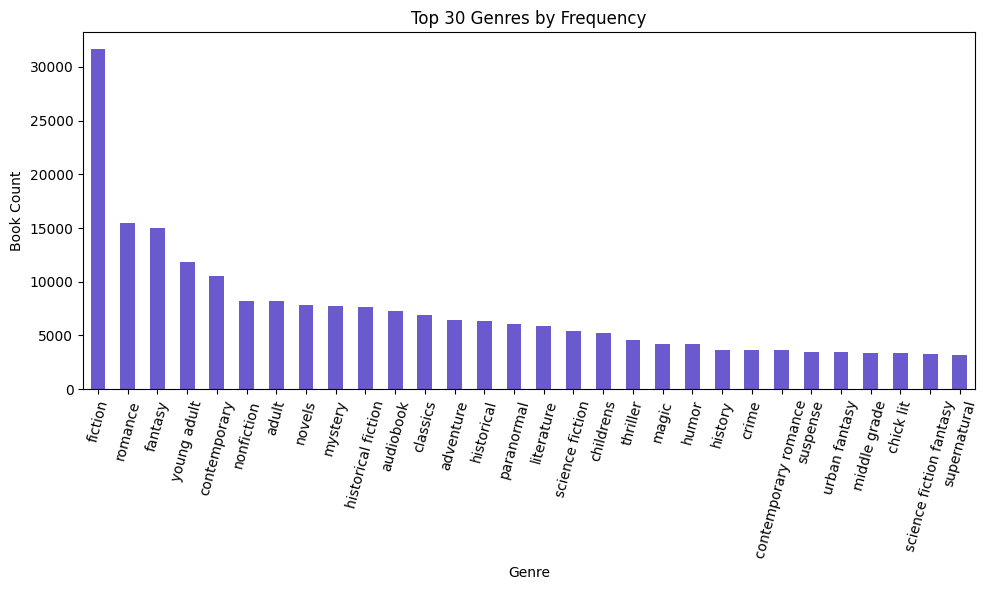

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
# convert to Series for easy analysis
genre_counts = pd.Series(unique_genres_dict).sort_values(ascending=False)
top_n = 30

#plot top N genres
top_n = 30
plt.figure(figsize=(10,6))
genre_counts.head(top_n).plot(kind='bar', color='slateblue')
plt.title(f"Top {top_n} Genres by Frequency")
plt.xlabel("Genre")
plt.ylabel("Book Count")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

The genre frequency plot reveals a highly skewed distribution typical of book markets, dominated by broad categories like _Fiction_ and _Romance_.

In [12]:
bbe_clean[['title','author_clean', 'genres_parsed', 'genres']].head()

,title,author_clean,genres_parsed,genres
0,The Hunger Games,Suzanne Collins,"[fiction, science fiction, action, young adult...","['Young Adult', 'Fiction', 'Dystopia', 'Fantas..."
1,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré","[fiction, young adult, classics, adventure, ch...","['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,To Kill a Mockingbird,Harper Lee,"[high school, fiction, historical fiction, lit...","['Classics', 'Fiction', 'Historical Fiction', ..."
3,Pride and Prejudice,"Jane Austen, Anna Quindlen","[fiction, historical fiction, literature, clas...","['Classics', 'Fiction', 'Romance', 'Historical..."
4,Twilight,Stephenie Meyer,"[fiction, vampires, young adult, teen, superna...","['Young Adult', 'Fantasy', 'Romance', 'Vampire..."


In [13]:
# calculate genre-level and book-level coverage
total_genres = genre_counts.sum()
top10 = set(genre_counts.head(10).index)

top10_share = (genre_counts.head(10).sum() / total_genres) * 100
mask_top10 = bbe_clean['genres_parsed'].apply(
    lambda lst: any(g in top10 for g in lst) if isinstance(lst, list) else False
)
book_share_top10 = (mask_top10.sum() / len(bbe_clean)) * 100

print(f"Top 10 genres account for {top10_share:.2f}% of all genre occurrences.")
print(f"Books with at least one of the top 10 genres: {book_share_top10:.2f}%")

Top 10 genres account for 30.47% of all genre occurrences.
Books with at least one of the top 10 genres: 86.54%


Broad, mainstream genres dominate both in tag volume and book coverage. Nearly one-third of all genre tags (**30.47%**) in the dataset come from the same 10 genres, showing strong catalog concentration. Nearly nine out of ten books (**86.54%**) fall within those top categories, confirming their dominance at the book level. This distribution supports the design of **segment-based recommendation strategies** for mainstream readers while maintaining a “long-tail” of niche genres to personalize discovery.  


Since genre tags are extremely long-tail: a few popular genres dominate while hundreds of niche labels appear rarely. Collapsing the tail into a single bucket (_other_) reduces feature sparsity, speeds up modeling, and keeps the vectors interpretable for the dashboard. This aligns with CRISP-DM Data Preparation and the assessment’s requirement to collect, arrange, and process data before modeling.

In [14]:
#simplification rules
TOP_K = 100          # keep the 100 most frequent genres
TAIL_LABEL = 'other' # name of the long-tail bucket
FILL_MISSING = True  # set to False if you prefer to leave NaNs

In [15]:
import pandas as pd
from collections import Counter

valid_lists = bbe_clean['genres_parsed'].dropna()
genre_counts = Counter(g for lst in valid_lists for g in lst)
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)
top_genres = set(genre_counts.head(TOP_K).index)

In [16]:
def simplify_genre_list(lst, *, keep=top_genres, tail=TAIL_LABEL):
    if not isinstance(lst, list):  # NaN / missing
        return ['unknown'] if FILL_MISSING else pd.NA
    kept = [g if g in keep else tail for g in lst]
    # dedupe while preserving order
    seen = set()
    simplified = [x for x in kept if not (x in seen or seen.add(x))]
    # if everything was mapped to tail and list became ['other'] it's fine; if it became empty, fill fallback
    return simplified or (['unknown'] if FILL_MISSING else pd.NA)

In [17]:
bbe_clean['genres_simplified'] = bbe_clean['genres_parsed'].apply(simplify_genre_list)

In [18]:
# % of rows simplified successfully
ok_share = bbe_clean['genres_simplified'].notna().mean() * 100
print(f"Simplified rows available: {ok_share:.2f}%")

# How many rows include the tail label
has_tail = bbe_clean['genres_simplified'].apply(lambda lst: isinstance(lst, list) and TAIL_LABEL in lst).sum()
print(f"Rows containing '{TAIL_LABEL}': {has_tail}")

# Coverage of the head vs tail (by occurrences)
from collections import Counter
simp_counts = Counter(g for lst in bbe_clean['genres_simplified'].dropna() for g in lst)
head_occ = sum(simp_counts[g] for g in simp_counts if g in top_genres)
tail_occ = simp_counts.get(TAIL_LABEL, 0)
total_occ = head_occ + tail_occ
print(f"Head coverage: {head_occ/total_occ*100:.2f}% | Tail coverage: {tail_occ/total_occ*100:.2f}%")

Simplified rows available: 100.00%
Rows containing 'other': 36763
Head coverage: 89.85% | Tail coverage: 10.15%


In [19]:
# sanity check
print(bbe_clean['genres_simplified'].apply(type).value_counts())
print(bbe_clean['genres_simplified'].head(3))

genres_simplified
<class 'list'>    52478
Name: count, dtype: int64
0    [fiction, science fiction, action, young adult...
1    [fiction, young adult, classics, adventure, ch...
2    [high school, fiction, historical fiction, lit...
Name: genres_simplified, dtype: object


In [20]:
import pandas as pd

def genre_completeness_report(df, columns):
    """
    Check completeness (non-empty lists) for given genre columns.
    Returns a DataFrame with counts and percentages.
    """
    total = len(df)
    summary = []
    
    for col in columns:
        mask_valid = df[col].apply(lambda x: isinstance(x, list) and len(x) > 0)
        valid = mask_valid.sum()
        missing = total - valid
        summary.append({
            "column": col,
            "total_books": total,
            "valid_genres": valid,
            "missing_genres": missing,
            "valid_%": round((valid / total) * 100, 2),
            "missing_%": round((missing / total) * 100, 2)
        })
    
    return pd.DataFrame(summary)

# completeness check
completeness = genre_completeness_report(
    bbe_clean, 
    ['genres_parsed', 'genres_simplified']
)
print("Genre Completeness Summary\n")
display(completeness)

Genre Completeness Summary



,column,total_books,valid_genres,missing_genres,valid_%,missing_%
0,genres_parsed,52478,47855,4623,91.19,8.81
1,genres_simplified,52478,52478,0,100.00,0.00


In [21]:
from pathlib import Path

version = 8

interim_bbe_path = Path("data/interim/bbe")

bbe_clean.to_csv(interim_bbe_path / f"bbe_clean_v{version}.csv", index=False)

print("Interim genres datasets saved successfully in data/interim/ directory.")

Interim genres datasets saved successfully in data/interim/ directory.


In [ ]:
import pandas as pd
bbe_clean = pd.read_csv('data/interim/bbe/bbe_clean_v8.csv')

**Awards**

In this step, we will reuse some of the functions created for Genres to process the awards. After a first analysis we can see that the data has a temporal component that adds noise and inconsistency to the feature. Since temporality is already being captured in the `firstPublicationDate` we will strip this to clean the data and, therefore, creating a clean function specific for awards.

In [34]:
bbe_clean[['title','awards']].head(3)

,title,awards
0,The Hunger Games,['Locus Award Nominee for Best Young Adult Boo...
1,Harry Potter and the Order of the Phoenix,['Bram Stoker Award for Works for Young Reader...
2,To Kill a Mockingbird,"['Pulitzer Prize for Fiction (1961)', 'Audie A..."


In [44]:
# identify and handle missing awards values
empty_awards_mask = (bbe_clean['awards'] == '[]')
empty_awards = bbe_clean[empty_awards_mask].shape[0]
share_missing_awards = (empty_awards / len(bbe_clean)) * 100
print(f'Books with empty genre values: {empty_awards} ({share_missing_awards:.2f}%)')

Books with empty genre values: 41864 (79.77%)


In [45]:
def clean_awards_list(lst):
    """
    Clean and normalize awards list:
    - Lowercase and remove punctuation noise
    - Remove year patterns like (2009) or (2010)
    - Deduplicate entries
    """
    if not isinstance(lst, list):
        return np.nan

    cleaned = []
    for a in lst:
        if not isinstance(a, str) or not a.strip():
            continue
        a = a.lower().strip()
        # remove (YYYY) patterns
        a = re.sub(r'\(\s*\d{4}\s*\)', '', a)
        # remove leftover punctuation and extra spaces
        a = re.sub(r'[^a-z0-9\s\-\&\'"]', '', a)
        a = re.sub(r'\s+', ' ', a).strip()
        cleaned.append(a)

    cleaned = list(set(cleaned))
    return cleaned if cleaned else np.nan


In [46]:
bbe_clean['awards_parsed'] = bbe_clean['awards'].apply(parse_list_field)
bbe_clean['awards_clean'] = bbe_clean['awards_parsed'].apply(clean_awards_list)
bbe_clean[['title','awards','awards_parsed','awards_clean']].head(3)

,title,awards,awards_parsed,awards_clean
0,The Hunger Games,['Locus Award Nominee for Best Young Adult Boo...,[Locus Award Nominee for Best Young Adult Book...,[oklahoma sequoyah award for high school and i...
1,Harry Potter and the Order of the Phoenix,['Bram Stoker Award for Works for Young Reader...,[Bram Stoker Award for Works for Young Readers...,"[anthony award for young adult, golden archer ..."
2,To Kill a Mockingbird,"['Pulitzer Prize for Fiction (1961)', 'Audie A...","[Pulitzer Prize for Fiction (1961), Audie Awar...","[pulitzer prize for fiction, national book awa..."


In [47]:
unique_awards_dict = count_unique_items(bbe_clean, 'awards_clean')
unique_awards_dict

{'oklahoma sequoyah award for high school and intermediate': 1,
 'premi protagonista jove for categoria 13-14 anys': 11,
 'evergreen teen book award': 28,
 'buxtehuder bulle': 22,
 'rhode island teen book award': 15,
 'teen buckeye book award': 6,
 'kinderboekwinkelprijs': 2,
 'michigan library association thumbs up award': 15,
 "pennsylvania young readers' choice award for young adults": 9,
 'lincoln award': 17,
 'new mexico land of enchantment award for young adult': 17,
 'eliot rosewater indiana high school book award': 20,
 'the inky awards shortlist for silver inky': 33,
 'books i loved best yearly bilby awards for older readers': 14,
 'soaring eagle book award': 23,
 'deutscher jugendliteraturpreis for preis der jugendjury': 13,
 'missouri truman readers award': 9,
 'prix et-lisez-moi': 3,
 'south carolina book award for junior and young adult book': 1,
 'georgia peach book award': 12,
 "grand prix de l'imaginaire nominee for roman jeunesse tranger": 11,
 'milwaukee county teen b

In [ ]:
# Boolean flag for books with any valid awards
bbe_clean['has_award'] = bbe_clean['awards_clean'].apply(
    lambda x: isinstance(x, list) and len(x) > 0
)
